# Author : Partha Pratim Das Gupta

In [3]:
import pandas as pd

yellowhammer = pd.read_csv('yellowhammer_features.csv')
stockdove = pd.read_csv('stockdove_features.csv')
greypartridge = pd.read_csv('greypartridge_features.csv')
turtledove = pd.read_csv('turtledove_features.csv')

In [4]:
# labeling
yellowhammer['T']=0
stockdove['T']=1
greypartridge['T']=2
turtledove['T']=3

In [5]:
# concatenate the dataframes
df = pd.concat([yellowhammer, stockdove, greypartridge, turtledove], ignore_index=True)

# select the desired columns
df = df.iloc[:, :137].join(df.iloc[:, 138:139])

df.head()

Unnamed: 0  zcr_mean  energy_mean  energy_entropy_mean  \
0           0  0.127553     0.002451             2.642476   
1           1  0.308621     0.001198             3.140290   
2           2  0.282321     0.003680             3.062770   
3           3  0.343893     0.001808             3.127342   
4           4  0.122818     0.004494             3.162092   

   spectral_centroid_mean  spectral_spread_mean  spectral_entropy_mean  \
0                0.166426              0.118785               0.932966   
1                0.338302              0.187876               2.189835   
2                0.322012              0.182890               1.914769   
3                0.357257              0.179270               2.150223   
4                0.160871              0.135722               1.255846   

   spectral_flux_mean  spectral_rolloff_mean  mfcc_1_mean  ...  \
0            0.005449               0.178300   -33.415757  ...   
1            0.001927               0.526887   -39.451200  ...   
2            0.003175               0.464856   -38.058953  ...   
3            0.002376               0.551025   -41.319402  ...   
4            0.002386               0.193911   -25.448259  ...   

   delta chroma_5_std  delta chroma_6_std  delta chroma_7_std  \
0            0.006707            0.006468            0.007191   
1            0.002298            0.002021            0.003769   
2            0.001535            0.001438            0.001217   
3            0.002655            0.003025            0.003218   
4            0.012075            0.006078            0.009614   

   delta chroma_8_std  delta chroma_9_std  delta chroma_10_std  \
0            0.003746            0.008123             0.006968   
1            0.004501            0.001098             0.001309   
2            0.001510            0.000827             0.001011   
3            0.002652            0.000797             0.001498   
4            0.003567            0.004633             0.009634   

   delta chroma_11_std  delta chroma_12_std  delta chroma_std_std  T  
0             0.005600             0.005946              0.002733  0  
1             0.002663             0.001147              0.001758  0  
2             0.000568             0.000789              0.002304  0  
3             0.001652             0.000755              0.001333  0  
4             0.007432             0.003799              0.003471  0  

[5 rows x 138 columns]

In [6]:
from sklearn.ensemble import IsolationForest
import pandas as pd

# Initialize the isolation forest model
isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model to your data
isolation_forest.fit(df)

# Use the model to predict the outliers
outliers = isolation_forest.predict(df)

# The predicted outliers are marked as -1 in the output array
outliers = pd.Series(outliers).replace({1: 0, -1: 1})

# Add the predicted outliers as a new column to the original dataframe
df['outlier'] = outliers

# Print the number of predicted outliers
print("Number of outliers: ", outliers.sum())


Number of outliers:  82


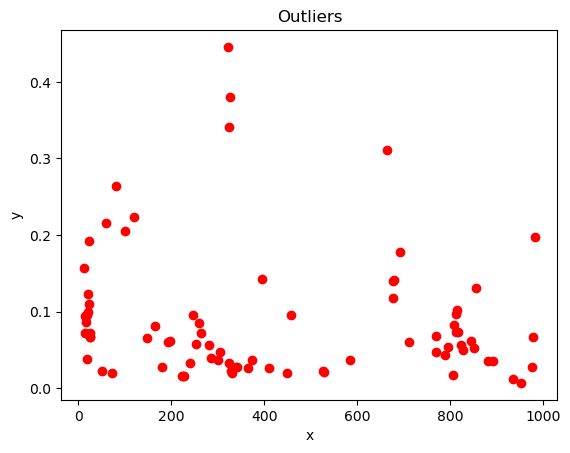

In [7]:
import matplotlib.pyplot as plt

# Filter the data to include only the outliers
outliers = df[df['outlier'] == 1]

# Plot the outliers
plt.scatter(outliers.iloc[:, :-1].values[:, 0], outliers.iloc[:, :-1].values[:, 1], color='red')

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers')

# Show the plot
plt.show()


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check which rows have all 0 values in each column
rows_with_all_zeros = df[df.eq(0).all(axis=1)]
# Print the number of rows with all zeros
print("rows with all Zero: ",len(rows_with_all_zeros))

# Check which rows have at least one missing value
rows_with_missing_values = df[df.isnull().any(axis=1)]
# Print the number of rows with missing values
print("missing_value: ",rows_with_missing_values.shape[0])


# Step 3: Check for duplicates
print("duplicate_value: ",df.duplicated().sum())

rows with all Zero:  0
missing_value:  0
duplicate_value:  0


In [9]:
from sklearn.preprocessing import StandardScaler

# separate the target variable
T= df['T']
data = df.drop('T', axis=1)

# scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# concatenate the target variable back to the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
scaled_df['T'] = T

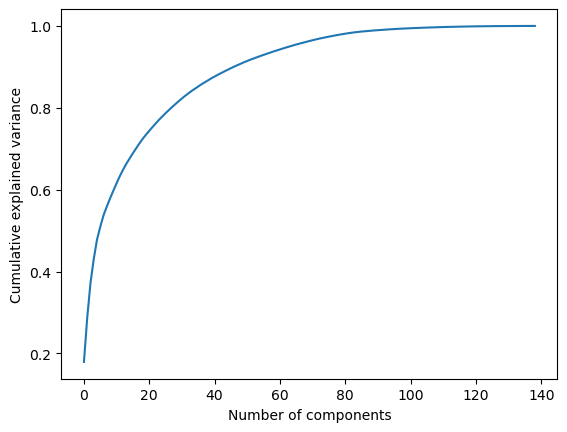

Number of components needed to explain at least 80% of the variance: 28


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# assume 'data' is your dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaled_df)

# create PCA instance
pca = PCA()

# fit and transform the scaled data
pca_data = pca.fit_transform(scaled_data)

# calculate the explained variance for each component
variance = pca.explained_variance_ratio_

# plot the explained variance
plt.plot(np.cumsum(variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

# find the number of components needed to explain at least 80% of the variance
n_components = np.argmax(np.cumsum(variance) >= 0.8) + 1

# print the number of components
print(f"Number of components needed to explain at least 80% of the variance: {n_components}")

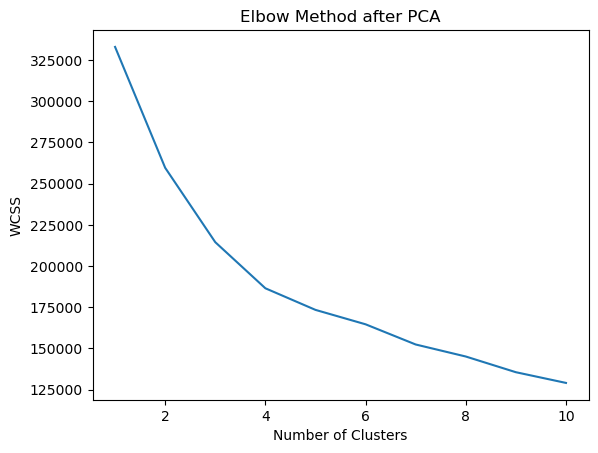

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# fit PCA and get transformed data
pca = PCA(n_components=10)
pca_data = pca.fit_transform(scaled_df)

# perform elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)
    
# plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method after PCA')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [12]:
from sklearn.cluster import KMeans

# fit PCA and get transformed data
pca = PCA(n_components=10)
pca_data = pca.fit_transform(scaled_df)

# perform K-means clustering
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_data)

# add cluster labels to dataframe
df['cluster_labels'] = cluster_labels

/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
# group the dataframe by cluster_labels
cluster_groups = df.groupby('cluster_labels')

# print the number of data points in each cluster
print("Number of data points in each cluster:")
print(cluster_groups.size())

# get the data points for each cluster separately
for i, (cluster_label, cluster_group) in enumerate(cluster_groups):
    print(f"\nCluster {cluster_label}:")
    print(cluster_group)

Number of data points in each cluster:
cluster_labels
0     631
1    1265
2    1351
3     753
dtype: int64

Cluster 0:
      Unnamed: 0  zcr_mean  energy_mean  energy_entropy_mean  \
64            64  0.037570     0.042880             3.136730   
86            86  0.108466     0.003612             3.108874   
108          108  0.038920     0.024349             3.171349   
112          112  0.049297     0.004349             2.993176   
115          115  0.038368     0.004834             2.948208   
...          ...       ...          ...                  ...   
3636         636  0.047228     0.004257             3.152403   
3652         652  0.045417     0.019152             3.102096   
3662         662  0.034501     0.002445             3.124981   
3924         924  0.045657     0.017979             2.985439   
3983         983  0.080778     0.039730             3.212883   

      spectral_centroid_mean  spectral_spread_mean  spectral_entropy_mean  \
64                  0.107833       

In [14]:
# create a new dataframe with cluster labels and target classes
cluster_df = df[['cluster_labels', 'T']]

# create a cross-tabulation table
cross_tab = pd.crosstab(cluster_df['T'], cluster_df['cluster_labels'])

# print the cross-tabulation table
print("Cross-tabulation table:")
print(cross_tab)

Cross-tabulation table:
cluster_labels    0    1    2    3
T                                 
0                28  258  702   12
1               487  166  317   30
2                34  745  154   67
3                82   96  178  644


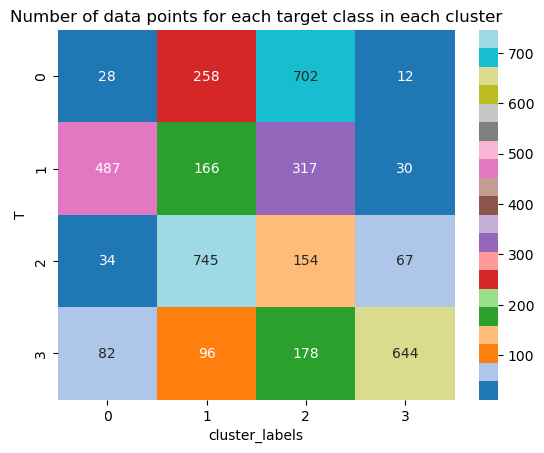

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a heatmap plot of the cross-tabulation table with a different color for each cluster
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='tab20')

# set the title of the plot
plt.title('Number of data points for each target class in each cluster')

# display the plot
plt.show()


In [16]:
import numpy as np

# Convert the cross-tabulation table to a numpy array
ct = np.array([[703, 12, 257, 28], [317, 31, 166, 486], [156, 67, 744, 33], [178, 644, 96, 82]])

# Calculate the total number of clips
total_clips = np.sum(ct)

# Calculate the proportion of clips in each group
group_props = np.sum(ct, axis=1) / total_clips

# Calculate the cluster purity for each group
cluster_purities = np.max(ct, axis=1) / np.sum(ct, axis=1)

# Print the results
for i in range(len(group_props)):
    print(f"Cluster {i}:  Cluster purity = {cluster_purities[i]:.2f}")

Cluster 0:  Cluster purity = 0.70
Cluster 1:  Cluster purity = 0.49
Cluster 2:  Cluster purity = 0.74
Cluster 3:  Cluster purity = 0.64


Cluster 2 has the highest purity score of 0.74, indicating that a relatively high percentage of the data points in this cluster share the same category. Clusters 0 and 3 also have moderately high purity scores of 0.70 and 0.64, respectively.However, Cluster 1 has a lower purity score of 0.49, suggesting that this cluster may be less well-defined or more heterogeneous in terms of the categories assigned to its data points.
So we can say that the birds of cluster 2 belong to the same group more consistently than the other clusters. However, all clusters have relatively high cluster purity values, which suggests that the clustering algorithm is effective at grouping the bird clips.